In [74]:
import os, sys, numpy as np, matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))

In [76]:
from Joel.joel_opt import (
    OptimizationProblem,
    OptimizationMethod,
    ClassicalNewton
)

In [75]:
def Rosenbrock(x):
    return 100 * (x[1] - x[0] ** 2) ** 2 + (1 - x[0]) ** 2

In [ ]:
# =========================
# Quasi-Newton Methods (Task 9)
# =========================

class QuasiNewtonBase(OptimizationMethod):
    """
    Base class for Quasi-Newton methods that carry an inverse-Hessian
    approximation H_k and use your golden-section line search.
    Subclasses implement _update(Hk, s, y, xk, gk, xk1, gk1) -> H_{k+1}.
    """
    def __init__(self, opt_problem: OptimizationProblem, tol: float = 1e-4, H0: np.ndarray | None = None):
        super().__init__(opt_problem, tol)
        self.H0 = H0  # if None -> identity

    # same central-difference fallback as ClassicalNewton.compute_grad
    def _compute_grad(self, x: np.ndarray):
        if self.obj_grad is not None:
            return self.obj_grad(x), 0
        fct = self.obj_fct
        dim = len(x)
        g = np.zeros(dim)
        dx = 1e-8
        for i in range(dim):
            xplus = x.copy(); xminus = x.copy()
            xplus[i] = x[i] + dx
            xminus[i] = x[i] - dx
            g[i] = (fct(xplus) - fct(xminus)) / (2 * dx)
        return g, 2 * dim

    # reuse your bracketing + golden-section logic, inlined here for independence
    def bracketing(self, b0, xk, dk):
        alpha = 2
        fct = self.obj_fct
        b = b0
        f0 = fct(xk)
        while fct(xk + b * dk) > f0:
            b = b / alpha
        k = 0
        while fct(xk + b * dk) < f0 and k < 1000:
            k += 1
            b = alpha * b
        return b

    def golden_section(self, b0, xk, dk):
        tol = 1e-4
        tau = (np.sqrt(5) - 1) / 2
        fct = self.obj_fct
        b = self.bracketing(b0, xk, dk)
        a = 0
        L = b
        ml = b - tau * L
        mr = tau * L
        while L >= tol:
            if fct(xk + ml * dk) < fct(xk + mr * dk):
                b = mr
                L = b - a
                mr = ml
                ml = b - tau * L
            else:
                a = ml
                L = b - a
                ml = mr
                mr = a + tau * L
        return [a, b]

    def _direction(self, Hk: np.ndarray, gk: np.ndarray) -> np.ndarray:
        return -Hk @ gk  # p_k = -H_k g_k

    def _update(self, Hk, s, y, xk, gk, xk1, gk1):
        raise NotImplementedError

    def solve(self, x0: np.ndarray, ls: bool = True, maxiter: int = 10_000):
        xk = x0.astype(float).copy()
        dim = len(xk)
        Hk = self.H0.copy() if self.H0 is not None else np.eye(dim)

        steps = [xk.copy()]
        it = 0

        # tolerances
        step_tol = self.tol
        grad_tol = self.tol

        while it < maxiter:
            it += 1

            # gradient at current iterate
            gk, _ = self._compute_grad(xk)

            # primary stopping: small gradient  (we’re near a flat spot (possible minimum).)
            if np.linalg.norm(gk) <= grad_tol:
                break

            # search direction from current H_k
            pk = self._direction(Hk, gk)

            # ensure descent: if not descent/downhill or not finite/invalid, fall back to steepest descent -g_k
            # 	Descent check: in my solve loop, after computing the direction p_k=-H_k g_k, I explicitly checked gk @ pk.
            # If it wasn’t a descent direction or was not finite, I fall back to steepest descent (pk = -gk).

            if not np.all(np.isfinite(pk)) or float(gk @ pk) >= 0.0:
                pk = -gk

            # step (line search or full step), Compute the new position x_{k+1}
            if ls:
                a, b = self.golden_section(1.0, xk, pk)
                alpha = 0.5 * (a + b)
                xk1 = xk + alpha * pk
            else:
                xk1 = xk + pk

            # compute new gradient and secant quantities
            gk1, _ = self._compute_grad(xk1)
            s = xk1 - xk # the actual step we took
            y = gk1 - gk #how the gradient changed

            # secondary stopping: tiny step and small gradient
            if np.linalg.norm(s) <= step_tol and np.linalg.norm(gk1) <= grad_tol:
                xk = xk1
                steps.append(xk.copy())
                break

            # curvature/quality guards, If the step or gradient change is extremely tiny → we can’t learn anything from it.
            # So, reset H_k = I to avoid “bad updates”.

            if np.linalg.norm(s) < 1e-16 or np.linalg.norm(y) < 1e-16:
                Hk = np.eye(dim)  # reset if information is useless
            else:
                Hk = self._update(Hk, s, y, xk, gk, xk1, gk1) #new inverse Hessian

            # move to next iterate
            xk = xk1
            steps.append(xk.copy())

        return np.vstack(steps)

### Quasi- Newton Methods

In [91]:
# --------- Good Broyden: rank-1 on G (= H^{-1}), Sherman–Morrison ----------
class GoodBroyden(QuasiNewtonBase):
    r"""
    Update B_{k+1} = B_k + ((y - B_k s) s^T)/(s^T s)
    Use Sherman–Morrison to update H_{k+1} = B_{k+1}^{-1} without inverting:
      H_{k+1} = H_k - (H_k u v^T H_k)/(1 + v^T H_k u),
      u = y - B_k s,  v = s/(s^T s).
    Implemented by solving H_k w = s (so w = B_k s) → u = y - w.
    """
    def _update(self, Hk, s, y, *_):
        ss = float(s @ s)
        if ss < 1e-18:
            return Hk
        # w = B_k s via H_k w = s
        w = np.linalg.solve(Hk, s)
        u = y - w
        v = s / ss
        denom = 1.0 + v @ (Hk @ u)
        if abs(denom) < 1e-18:
            return Hk
        Hu = Hk @ u
        vTH = v @ Hk
        return Hk - np.outer(Hu, vTH) / denom

In [92]:
# --------- Bad Broyden: rank-1 directly on H ----------
class BadBroyden(QuasiNewtonBase):
    r"""
    H_{k+1} = H_k + ((s - H_k y) y^T)/(y^T y)
    (satisfies secant H_{k+1} y = s; generally non-symmetric).
    """
    def _update(self, Hk, s, y, *_):
        yy = float(y @ y)
        if yy < 1e-18:
            return Hk
        Hy = Hk @ y
        return Hk + np.outer(s - Hy, y) / yy

In [93]:
# --------- Symmetric Broyden (SR1) ----------
class SymmetricBroydenSR1(QuasiNewtonBase):
    r"""
    SR1 (symmetric rank-1):
      r = s - H_k y
      H_{k+1} = H_k + (r r^T)/(r^T y)
    Use a skip rule if |r^T y| is too small.
    """
    def _update(self, Hk, s, y, *_):
        r = s - Hk @ y
        denom = float(r @ y)
        if abs(denom) < 1e-12:
            return Hk  # skip for stability
        return Hk + np.outer(r, r) / denom

In [94]:
# --------- DFP (Davidon–Fletcher–Powell, rank-2, symmetric) ----------
class DFP(QuasiNewtonBase):
    r"""
    H_{k+1} = H_k + (s s^T)/(y^T s) - (H_k y y^T H_k)/(y^T H_k y)
    """
    def _update(self, Hk, s, y, *_):
        ys = float(y @ s)
        if abs(ys) < 1e-18:
            return Hk  # skip on bad curvature
        Hy = Hk @ y
        yHy = float(y @ Hy)
        if abs(yHy) < 1e-18:
            return Hk
        return Hk + np.outer(s, s) / ys - np.outer(Hy, Hy) / yHy

In [95]:
# --------- BFGS (rank-2, symmetric, positive-definite if y^T s > 0) ----------
class BFGS(QuasiNewtonBase):
    r"""
    ρ = 1/(y^T s)
    H_{k+1} = (I - ρ s y^T) H_k (I - ρ y s^T) + ρ s s^T
    """
    def _update(self, Hk, s, y, *_):
        ys = float(y @ s)
        if ys <= 1e-18:
            return Hk  # maintain stability
        rho = 1.0 / ys
        I = np.eye(len(s))
        V = I - rho * np.outer(s, y)
        return V @ Hk @ V.T + rho * np.outer(s, s)

### Testing

In [97]:
# problem
def rosen(x):
    return 100*(x[1]-x[0]**2)**2 + (1-x[0])**2
def rosen_grad(x):  # analytic grad for plotting ||∇f||
    dfdx = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    dfdy =  200*(x[1]-x[0]**2)
    return np.array([dfdx, dfdy], dtype=float)

x0 = np.array([-0.5, 3.0], dtype=float)
op = OptimizationProblem(rosen)

methods = [
    ("Good Broyden",  GoodBroyden(op, tol=1e-6)),
    ("Bad Broyden",   BadBroyden(op,  tol=1e-6)),
    ("SR1",           SymmetricBroydenSR1(op, tol=1e-6)),
    ("DFP",           DFP(op,         tol=1e-6)),
    ("BFGS",          BFGS(op,        tol=1e-6)),
]

results = {}
summary = []
for name, M in methods:
    steps = M.solve(x0, ls=True, maxiter=20000)  # big cap for bad Broyden
    fx = np.array([rosen(s) for s in steps])
    gnorm = np.array([np.linalg.norm(rosen_grad(s)) for s in steps])
    results[name] = {"steps": steps, "fx": fx, "gnorm": gnorm}
    summary.append((name, len(steps)-1, steps[-1], fx[-1], gnorm[-1]))

# pretty print summary
print("Method              iters   final x                     f(x_final)         ||grad||")
for name, iters, xfin, ffin, gfin in summary:
    print(f"{name:16s} {iters:6d}   [{xfin[0]: .8f}, {xfin[1]: .8f}]   {ffin: .3e}   {gfin: .3e}")

Method              iters   final x                     f(x_final)         ||grad||
Good Broyden        140   [ 1.00000000,  1.00000000]    3.634e-20    2.082e-10
Bad Broyden        6629   [ 0.99999890,  0.99999780]    1.207e-12    9.977e-07
SR1                  26   [ 0.99999993,  0.99999987]    4.555e-15    5.860e-07
DFP                  22   [ 1.00000000,  1.00000000]    2.103e-17    2.024e-07
BFGS                 22   [ 1.00000000,  1.00000000]    2.122e-17    2.027e-07


- Final x - Optimization paths on Rosenbrock: all methods ended extremely close to the true minimizer [1,1].
- f(x_final)- Objective value per iteration; Log-scale plot of f(x_k): objective value is ≈0 (tiny numbers → essentially machine precision).
- ||grad|| - Gradient norm per iteration on log scale: gradient norms are very small → confirms convergence. (measure of convergence to a stationary point.)

### Visualization

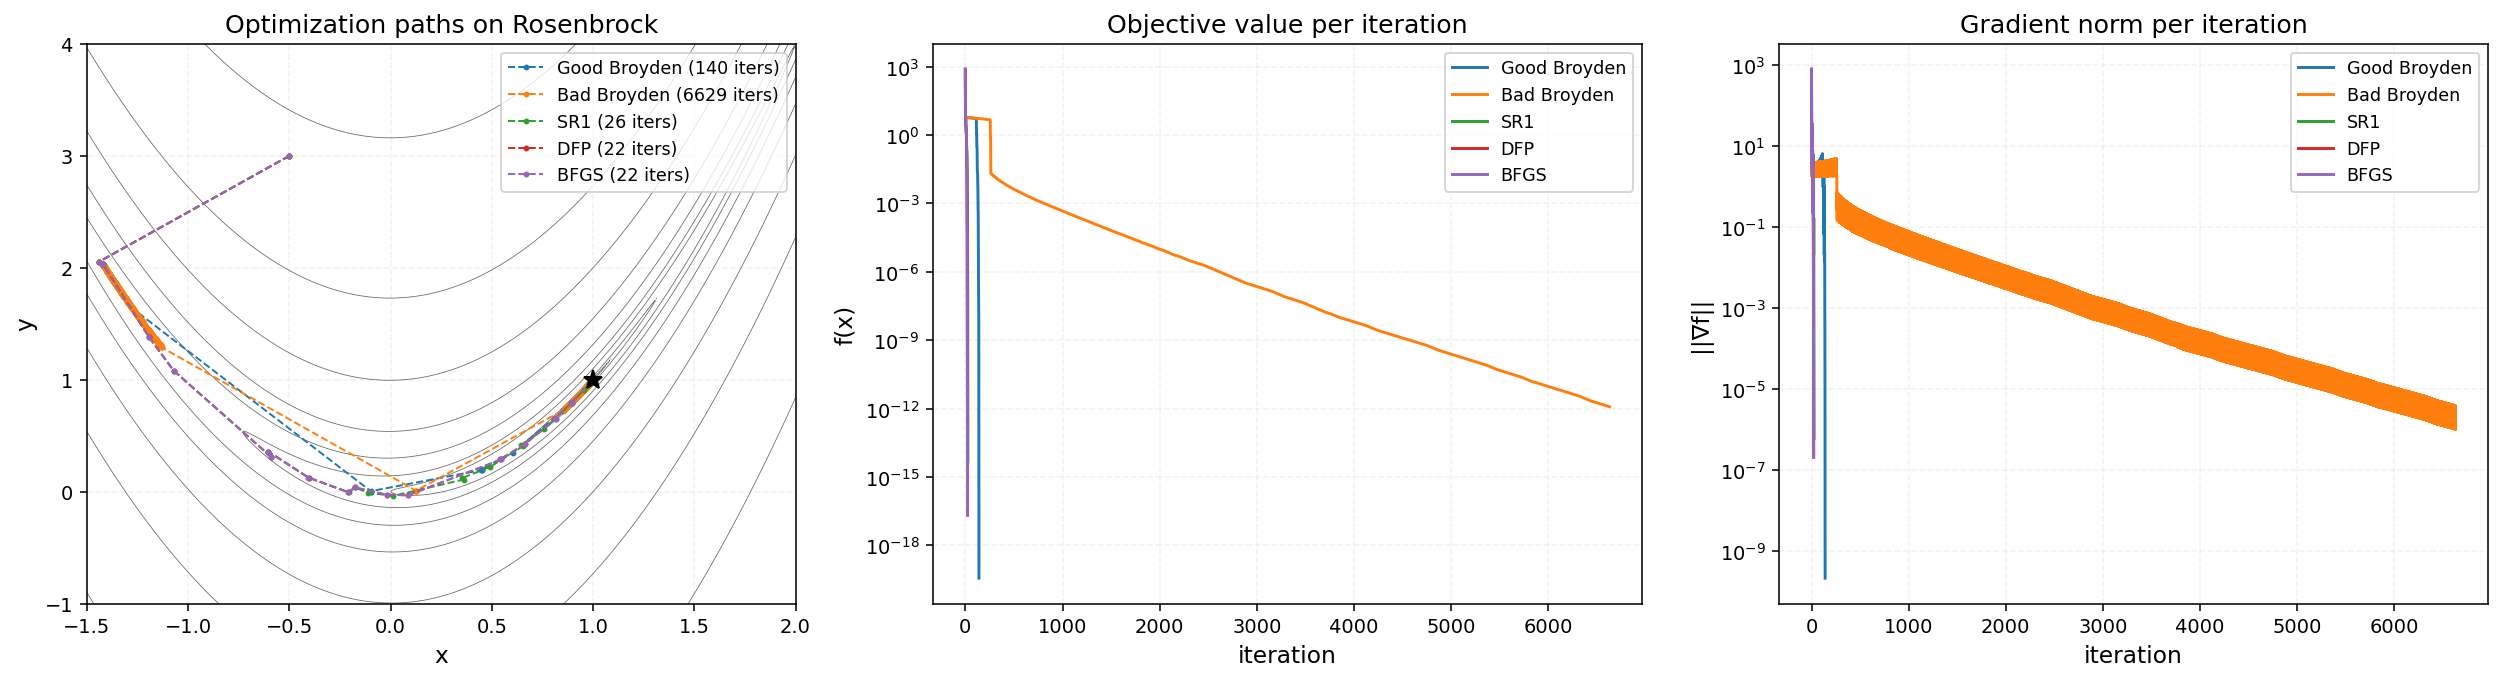

In [98]:
# background contours
xgrid = np.linspace(-1.5, 2.0, 500)
ygrid = np.linspace(-1.0, 4.0, 500)
X, Y = np.meshgrid(xgrid, ygrid)
Z = 100*(Y - X**2)**2 + (1 - X)**2
levels = [1e-3,1e-2,1e-1,1,3,10,30,100,300,1e3,3e3]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (A) Trajectories
ax = axes[0]
ax.contour(X, Y, Z, levels=levels, colors="black", linewidths=0.4, alpha=0.6)
palette = {
    "Good Broyden":"tab:blue",
    "Bad Broyden":"tab:orange",
    "SR1":"tab:green",
    "DFP":"tab:red",
    "BFGS":"tab:purple",
}
for name in palette:
    S = results[name]["steps"]
    ax.plot(S[:,0], S[:,1], marker="o", markersize=2, linewidth=1.0,
            linestyle="--", color=palette[name], label=f"{name} ({len(S)-1} iters)")
ax.plot(1,1,"k*",markersize=10)
ax.set_title("Optimization paths on Rosenbrock")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.legend(loc="upper right", fontsize=9)

# (B) f(x_k) vs iteration (log y)
ax = axes[1]
for name in palette:
    fx = results[name]["fx"]
    ax.semilogy(fx, label=name, linewidth=1.5)
ax.set_title("Objective value per iteration")
ax.set_xlabel("iteration"); ax.set_ylabel("f(x)")
ax.legend(fontsize=9)

# (C) ||grad|| vs iteration (log y)
ax = axes[2]
for name in palette:
    gnorm = results[name]["gnorm"]
    ax.semilogy(gnorm, label=name, linewidth=1.5)
ax.set_title("Gradient norm per iteration")
ax.set_xlabel("iteration"); ax.set_ylabel("||∇f||")
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()